In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
import sys
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style, get_max_available_L
from TCGA_files import get_tcga_tissue

In [ ]:
#label = 'disease_type'
labels = ['primary_site', 'secondary_site']
label=labels[0]
algorithm = "topsbm"
directory='/home/fvalle/phd/datasets/gtex/log/3000_random-5000hvg/'
L = get_max_available_L(directory, algorithm)

In [ ]:
df = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L))
df.head()

### Specific topic

In [ ]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, L, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [ ]:
l=L

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files['primary_site'].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [39]:
l=L

In [40]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = pd.read_csv("%s/files.dat"%directory, index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)['SMTS']))

<Figure size 432x288 with 0 Axes>

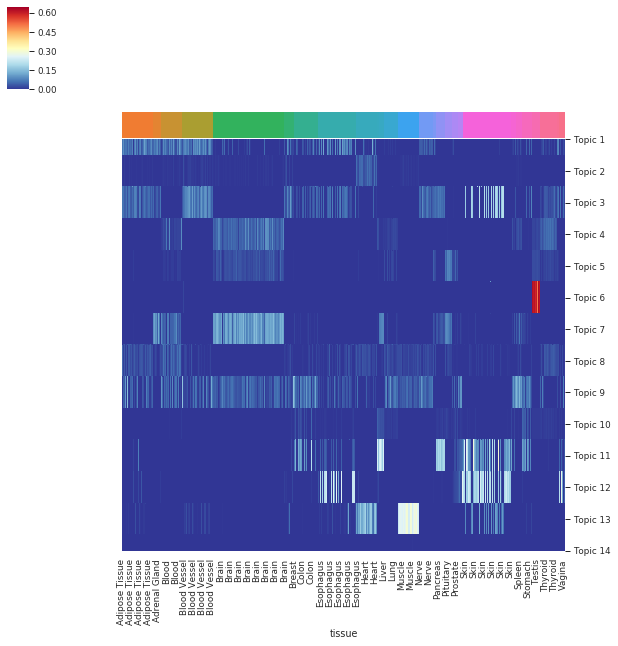

In [41]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', vmin=0, cmap='RdYlBu_r', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.pdf"%(directory,l))

In [42]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)['SMTS'])

Thyroid
Colon
Blood
Spleen
Pituitary
Brain
Skin
Esophagus
Lung
Adrenal Gland
Adipose Tissue
Breast
Small Intestine
Muscle
Stomach
Salivary Gland
Testis
Nerve
Blood Vessel
Ovary
Pancreas
Vagina
Heart
Cervix Uteri
Prostate
Liver
Kidney
Bladder
Uterus
Fallopian Tube


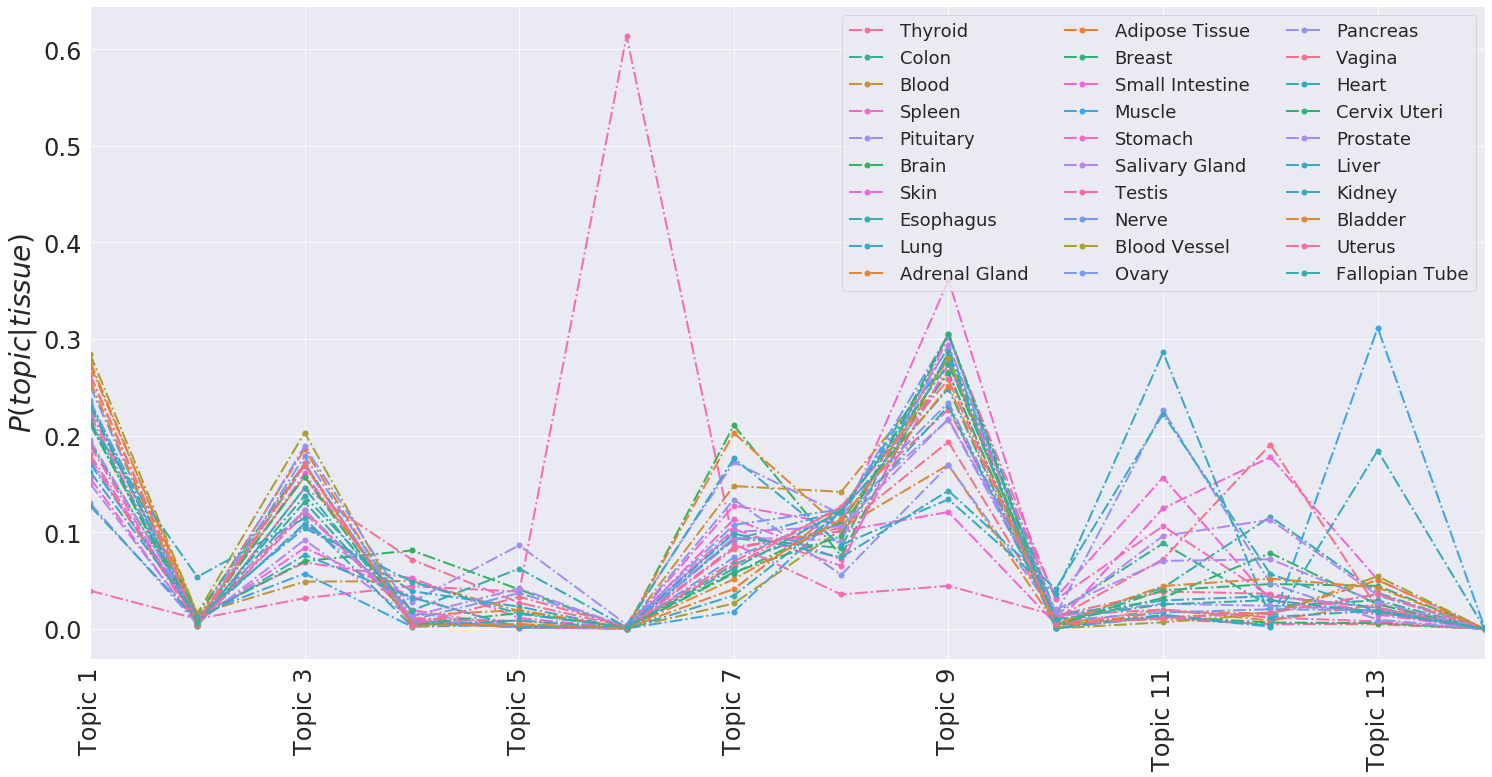

In [43]:
fig = plt.figure(figsize=(25,12))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:]].mean(axis=0).plot(ls=ls,marker=marker, lw=2, ms=10, label=tissue, c=network_lut[df_files[df_files['SMTS']==tissue]['SMTS'][0]])
    except:
        print(sys.exc_info()[0])
plt.xticks(rotation=90, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("$P(topic | tissue)$", fontsize=28)
plt.legend(fontsize=18, ncol=3)
#plt.xscale('log')
#plt.yscale('log')
plt.show()
fig.savefig("%s/%s/lifeplot.pdf"%(directory,algorithm))

In [44]:
import findspark
findspark.init()
import pyspark as spark
import tensorflow as tf
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
try:
    if sc:
        sc.stop()
except:
    pass
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [45]:
df_files_pd = pd.read_csv("%s/files.dat"%directory, index_col=0).dropna(how='all', axis=0)
df_topics = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_topic_list = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topics.csv"%(directory,algorithm,algorithm,l))
df_files = sql.read.option("header","true").csv("%s/files.dat"%(directory))
df_files.registerTempTable("file")
df_topics = df_topics.withColumn('status', udf(lambda x: 'healthy' if 'GTEX' in x else 'tumour', StringType())(col('doc')))
df_topics = df_topics.withColumn('tissue', udf(lambda x: get_file(x, df_files_pd)['SMTS'], StringType())(col('doc')))
#df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)[labels[1]], StringType())(col('doc')))
df_topics.registerTempTable("topic")

### only health vs disease

In [ ]:
dftf_h = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='healthy'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='tumour'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)

In [ ]:
with tf.Session() as sess:
    results = sess.run(tf.sort([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)], axis=1, direction='DESCENDING'))

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0], marker='o', lw=0.1)
plt.plot(results[1],marker='x', lw=0.1)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
df_topics

In [ ]:
topic_cols=df_topics.columns[2:-3]
look_for = ['colon', 'colon-gtex','colon-tcga']
exprs = {x: "avg" for x in topic_cols}
df_tissue_healthy=df_topics.filter(col('tissue')==look_for[0]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]
df_tissue_disease=df_topics.filter(col('tissue')!=look_for[2]).select(topic_cols).agg(exprs).toPandas()[["avg(%s)"%topic for topic in topic_cols]]

In [ ]:
df_topics.groupby('tissue').count().show()

In [ ]:
means = df_topics.groupby(['status','tissue']).agg(exprs).agg({x: 'avg' for x in ["avg(%s)"%t for t in topic_cols]}).toPandas()[["avg(avg(%s))"%topic for topic in topic_cols]]
means.columns=topic_cols
sigmas = df_topics.groupby(['status','tissue']).agg({x: "std" for x in topic_cols}).agg({x: 'std' for x in ["stddev(%s)"%t for t in topic_cols]}).toPandas()[["stddev(stddev(%s))"%topic for topic in topic_cols]]
sigmas.columns=topic_cols
df_topics_grouped = df_topics.groupby(['status','second_tissue']).agg(exprs)
for topic in topic_cols:
    plt.figure()
    plt.title(topic)
    healthy=(df_topics.filter(col('tissue')==look_for[0]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    disease=(df_topics.filter(col('tissue')!=look_for[0]).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
    plt.hist(healthy.values.T[0], density=True, histtype='step', label=look_for[0])
    plt.hist(disease.values.T[0], density=True, histtype='step', label='Other')
    plt.vlines([healthy.mean(),disease.mean().values],0,0.2,colors=['blue','orange'], linestyles=['dashed','dashed'])
    plt.vlines([-3,3],0,0.2,colors=['k','k'])
    plt.legend()
    plt.show()

In [ ]:
for g in df_topic_list.select("Topic 5").dropna().toPandas().values.T[0]:
    print(g)

In [ ]:
for topic in topic_cols:
    plt.figure(figsize=(15,8))
    plt.title(topic)
    for tissue in df_topics.select('second_tissue').distinct().toPandas().values.T[0]:
        tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
        plt.hist(tissue_spec.values.T[0], density=True, histtype='step', label=tissue)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
df_topics_grouped = df_topics.groupby('second_tissue').agg({x: 'avg' for x in topic_cols}).toPandas().set_index('second_tissue')[["avg(%s)"%t for t in topic_cols]].transpose()
df_topics_grouped.index=topic_cols

In [ ]:
df_cmap = df_topics_grouped
df_cmap=df_cmap.subtract(df_cmap.mean(axis=1), axis=0).divide(df_cmap.std(axis=1), axis=0)
df_cmap.sort_index(axis=1, inplace=True)
#df_cmap.sort_values(by=[c for c in df_cmap.columns[::2]], inplace=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', cmap='RdYlBu', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [ ]:
fig=plt.figure(figsize=(10,8))
#plt.plot((df_tissue).values[0], label=look_for[0], ls='--', ms=10)
plt.hist((df_tissue_healthy).values[0], label=look_for[1], marker='x', lw=0.5, ms=10)
plt.hist((df_tissue_disease).values[0], label=look_for[2], marker='x', lw=0.5, ms=10)
plt.xticks(ticks=np.arange(len(topic_cols)), labels=topic_cols, rotation=90)
#plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

In [ ]:
(df_tissue_healthy-df_tissue).values

### all

In [46]:
df_all = tf.convert_to_tensor(sql.sql("SELECT * FROM topic").toPandas().drop(['i_doc', 'doc', 'status', 'tissue'], axis=1).astype(float).values)

In [47]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
#normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [48]:
result = normed_df.numpy()

Skin
Adrenal Gland
Adipose Tissue
Pituitary
Salivary Gland
Spleen
Colon
Nerve
Blood
Kidney
Blood Vessel
Muscle
Prostate
Small Intestine
Esophagus
Bladder
Liver
Stomach
Thyroid
Heart
Fallopian Tube
Pancreas
Vagina
Brain
Uterus
Lung
Testis
Ovary
Breast
Cervix Uteri


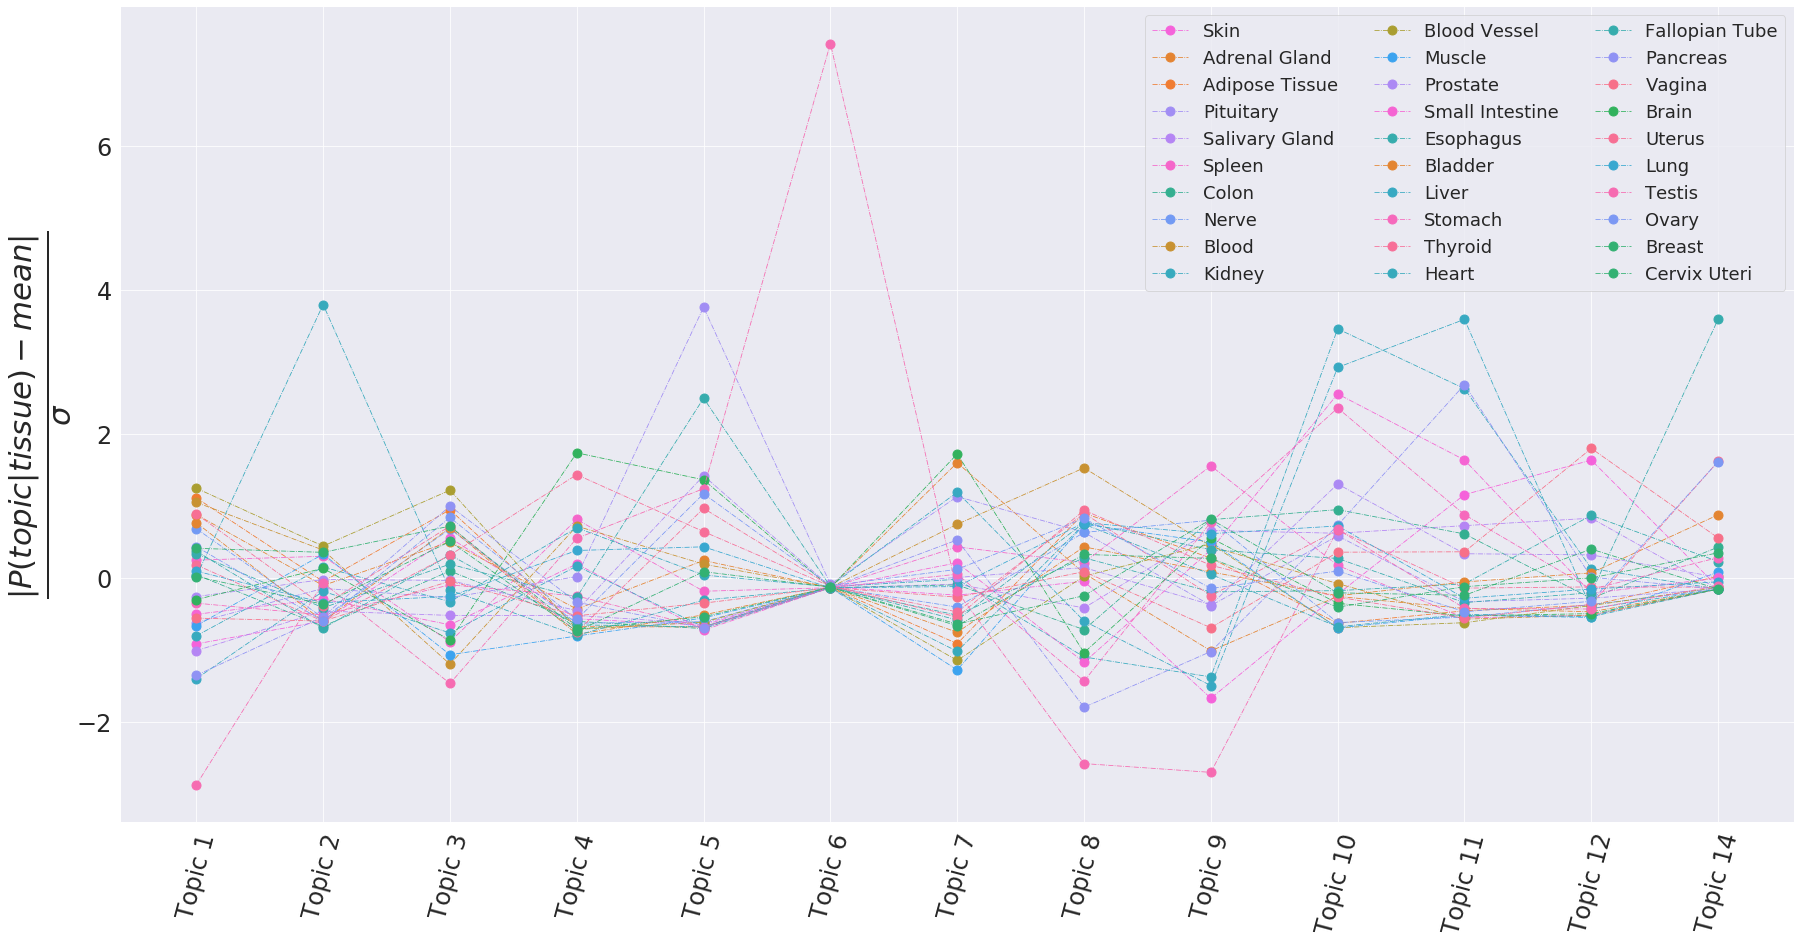

In [49]:
fig=plt.figure(figsize=(30,15))
topics_i = np.linspace(0,df_all.shape[1]-1,df_all.shape[1]-1, dtype=int)
label = 'tissue'
for tissue in df_topics.select('tissue').distinct().toPandas().values.ravel():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    c = network_lut[tissue]
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    plt.plot(np.mean(result[i_docs],axis=0)[topics_i], marker=marker, lw=0.8, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=18, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=44)
plt.xticks(np.linspace(0,len(topics_i)-1,num=len(topics_i)), ["Topic %d"%(t+1) for t in topics_i], rotation=75, fontsize=24)
plt.tick_params(labelsize=24)
#plt.yscale('log')
plt.show()
fig.savefig("%s/%s/lifeplot_normalised_level%d.pdf"%(directory,algorithm,l))

In [ ]:
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = sql.sql("SELECT * FROM topic WHERE tissue='%s'"%tissue).toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/%s/topicvisual_%s.png"%(directory,algorithm,tissue))

In [ ]:
tf.reset_default_graph()
sc.stop()